# Notebook for testing how distortions change in Normalizing Flows

In [1]:
import normflows as nf
from normflows import flows
## Standard libraries
import os
import math
import time
import numpy as np 

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tdata
import torch.optim as optim

import dgl #NOTE: for dgl.batch and dgl.unbatch
from dgl import save_graphs, load_graphs
from dgl.data import DGLDataset
from dgl.dataloading import GraphDataLoader
from dgl.data.utils import save_info, load_info, Subset

import umap
reducer = umap.UMAP();
from tqdm import tqdm

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

/hpc/group/vossenlab/rck32/miniconda3/envs/venv/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/hpc/group/vossenlab/rck32/miniconda3/envs/venv/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/hpc/group/vossenlab/rck32/miniconda3/envs/v

Using device cuda:0


In [2]:
#custom imports
from utils import load_graph_dataset, train, evaluate, GraphDataset, get_graph_dataset_info
from models import GIN, HeteroGIN
from NF_utils import Latent_data, create_latent_data, get_masked_affine, transform, train,plot_loss, test,plot_9_histos, plot_UMAP_sidebyside,plot_UMAP_overlay
from GAN_utils import GAN_Input

Using device cuda:0


In [3]:
from numpy.random import default_rng
rng = default_rng()


In [4]:
'''                                              '''
'''     SETTING UP LATENT SPACE REPRESENTATION   '''
'''                                              '''

# Data and MC both have the same prefix
prefix = "/hpc/group/vossenlab/mfm45/.dgl/"

# MC inside Lambda_train_matched_jobs_outbending_cache_bg50nA_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized
MCdataset = "Lambda_train_matched_jobs_outbending_cache_bg50nA_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized"

# Data inside data_jobs_rga_fall2018_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized
DATAdataset = "data_jobs_rga_fall2018_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized"


In [5]:
num_samples = 100
MC_Graphs = GraphDataset(prefix+MCdataset)

#pid dictionary:
pid_dict = {
    0 : "photon",
    1 : "electron",
    -1 : "positron",
    0.8 : "proton",
    -0.8 : "anti-proton",
    0.5 : "neutron",
    -0.5 : "anti-neutron",
    0.1 : "pi0",
    0.6 : "pi+",
    -0.6 : "pi-",
    0.3 : "K0",
    0.4 : "K+",
    -0.4 : "K-"
}

In [6]:
distorted_inputs = GAN_Input(MC_Graphs, distortion_range = (-0.02,0.02))
inputs = GAN_Input(MC_Graphs, distort = True)

In [7]:
def get_masked_affine(num_layers = 32, latent_dim = 71, hidden_dim = 142):
    #mask
    b = torch.ones(latent_dim)
    for i in range(b.size()[0]):
        if i % 2 == 0:
            b[i] = 0
    masked_affine_flows = []
    for i in range(num_layers):
        s = nf.nets.MLP([latent_dim, hidden_dim, hidden_dim, latent_dim])
        t = nf.nets.MLP([latent_dim, hidden_dim,hidden_dim, latent_dim])
        if i % 2 == 0:
            masked_affine_flows += [nf.flows.MaskedAffineFlow(b, t, s)]
        else:
            masked_affine_flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
    return masked_affine_flows

In [8]:
# SETTING UP DATA MODEL

masked_affine_flows_train_distort = get_masked_affine(latent_dim = 6, hidden_dim = 20)
distribution_distort = nf.distributions.DiagGaussian(inputs.num_sample_features, trainable = False)
masked_affine_model_distort = nf.NormalizingFlow(q0=distribution_distort, flows=masked_affine_flows_train_distort)
distort_model = masked_affine_model_distort.to(device)

In [9]:
# SETTING UP MC MODEL

masked_affine_flows_train_MC = get_masked_affine(latent_dim = 6,hidden_dim = 20)
distribution_MC = nf.distributions.DiagGaussian(inputs.num_sample_features, trainable = False)
masked_affine_model_MC = nf.NormalizingFlow(q0=distribution_MC, flows=masked_affine_flows_train_MC)
MC_model = masked_affine_model_MC.to(device)

  0%|          | 0/1306 [01:36<?, ?it/s]


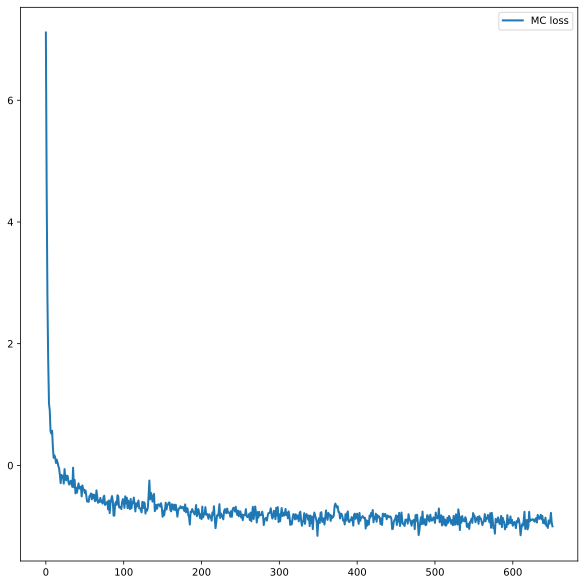

Lowest Loss: -1.1578031420707702


In [10]:
# TRAINING MC
MC_loss, MC_full_loss = train(inputs, MC_model, distorted = False, num_epochs = 5,compact_num = 10)
plot_loss(MC_loss, label = "MC loss")

In [11]:
MC_model.save("models/NF_MC/MC_distortion_july_11.pth")

  0%|          | 0/1306 [01:35<?, ?it/s]


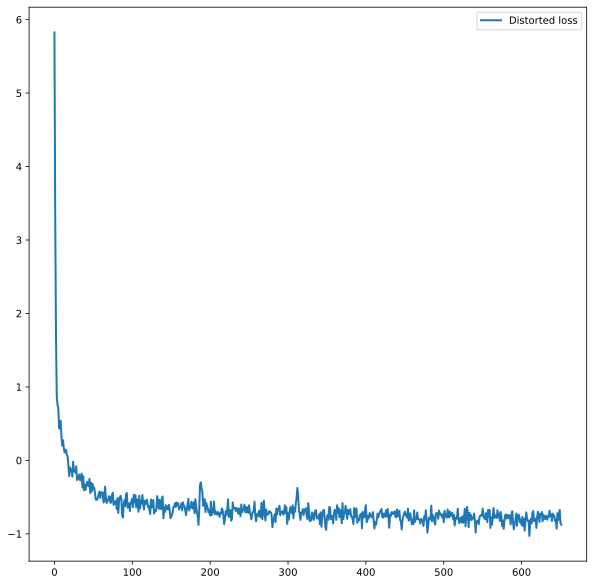

Lowest Loss: -1.0287911891937256


In [12]:
# TRAINING Distorted
distort_loss, distort_full_loss = train(inputs, distort_model, distorted = True, num_epochs = 5, compact_num = 10)
plot_loss(distort_loss, label = "Distorted loss")

In [13]:
MC_model.save("models/NF_DATA/DATA_distortion_july_11.pth")

# Testing MC and DATA models

In [14]:
# Testing MC
test(inputs, MC_model, data_type = "MC")
# Testing DATA
test(distorted_inputs, distort_model, data_type = "MC distorted", distorted = True)

100%|██████████| 1306/1306 [00:26<00:00, 49.42it/s]


MC average loss: -0.9213853478431702


100%|██████████| 1306/1306 [00:25<00:00, 51.12it/s]

MC distorted average loss: -0.8629641532897949


# Plotting sanity checks

In [16]:
def transform(in_data, model, reverse = True, distorted = False):
    data_tensor = torch.zeros(in_data.num_events,6)
    model.eval()
    with torch.no_grad():
        for it in tqdm(range(in_data.max_iter), position = 0, leave=True):
            if(distorted):
                test_samples = in_data.sample(iteration = it, distorted = True).to(device)
            else:
                test_samples = in_data.sample(iteration = it).to(device)
#             test_samples = test_samples.to(device)
            if(reverse):
                output_batch = model.inverse(test_samples)
            else:
                output_batch = model.forward(test_samples)
            for i in range(in_data.batch_size):
                data_tensor[it*in_data.batch_size + i] = output_batch[i]
    return data_tensor

In [17]:
normalized_MC = transform(inputs, MC_model)
normalized_distorted = transform(distorted_inputs, distort_model, distorted = True)

100%|██████████| 1306/1306 [00:25<00:00, 50.29it/s]


In [18]:
normalized_distorted_obj = Latent_data(normalized_distorted, torch.empty([]))
normalized_distorted_obj.set_batch_size(100)
full_pass_distorted = transform(normalized_distorted_obj, MC_model, reverse = False)

100%|██████████| 1306/1306 [00:24<00:00, 54.27it/s]


In [19]:
def plot_6_histos(data_tensor, color,bins = 150, description = "none", save = False, save_loc = "plots/img.jpeg"):
    histos, ((h11,h12,h13),(h21,h22,h23)) = plt.subplots(2,3, figsize = (10,7))
    if description == "none":
        histos.suptitle("Several 1D Histos")
    else:
        histos.suptitle(f"Several 1D Histos {description}")
    hlist = [h11,h12,h13,h21,h22,h23]
    for i in range(len(hlist)):
        hlist[i].hist(data_tensor[:,i], bins=150,color=color, density = True);
        hlist[i].set_xlim([-1,1])
    plt.show()
    if(save):
        histos.savefig(save_loc)

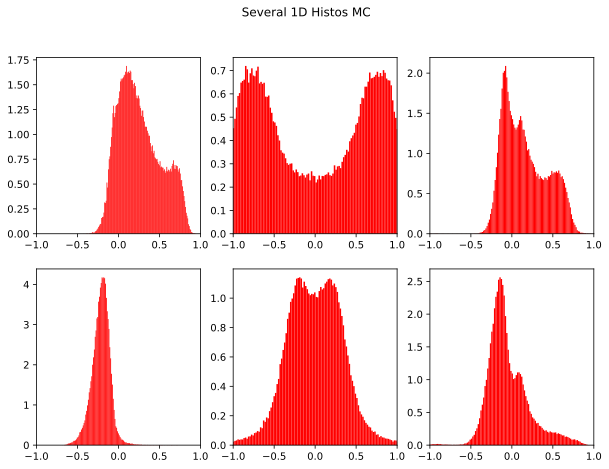

In [20]:
plot_6_histos(inputs.data,'r', description = "MC", save = False, save_loc = "plots/NF/six_hists_MC.jpeg")

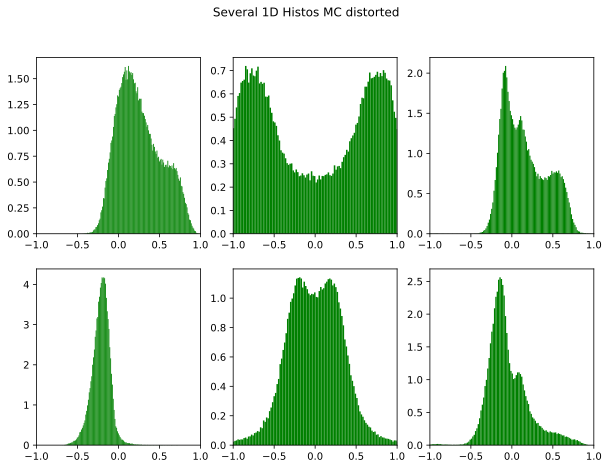

In [21]:
plot_6_histos(inputs.distorted_features,'g', description = "MC distorted", save = False, save_loc = "plots/NF/six_hists_MC_distort_0_02.jpeg")

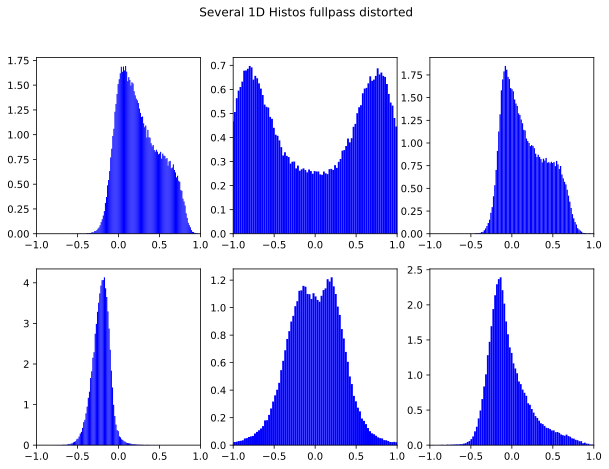

In [22]:
plot_6_histos(full_pass_distorted,'b', description = 'fullpass distorted', save = False, save_loc = "plots/NF/six_hists_fullpass_0_02.jpeg")

In [29]:
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap

# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap=white_viridis)
    fig.colorbar(density, label='Number of points per pixel')



Smearing Matrix

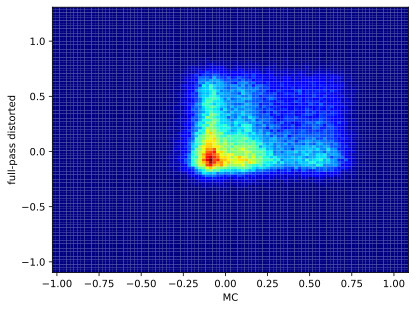

In [43]:
x1 = torch.Tensor.numpy(inputs.data[:,2])
y1 = torch.Tensor.numpy(full_pass_distorted[:,2])
plt.hist2d(x1,y1,bins = 100, cmap = plt.cm.jet)
plt.xlabel("MC")
plt.ylabel("full-pass distorted")
plt.show()
# plt.savefig("plots/GAN/MC_vs_distored_pT.jpeg")

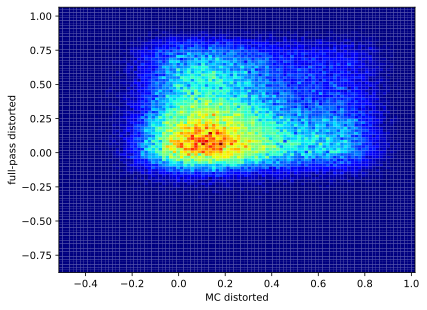

In [40]:
x1 = torch.Tensor.numpy(inputs.distorted_features[:,0])
y1 = torch.Tensor.numpy(full_pass_distorted[:,0])
plt.hist2d(x1,y1,bins = 100, cmap = plt.cm.jet)
plt.xlabel("MC distorted")
plt.ylabel("full-pass distorted")
plt.show()
# plt.savefig("plots/GAN/MC_vs_distored_pT.jpeg")

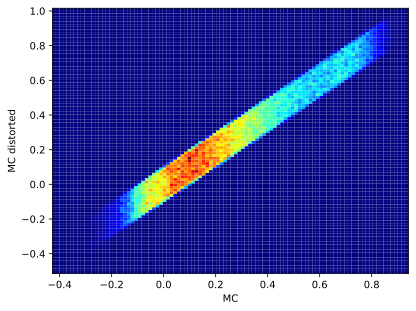

In [41]:
y1 = torch.Tensor.numpy(inputs.distorted_features[:,0])
x1 = torch.Tensor.numpy(inputs.data[:,0])
plt.hist2d(x1,y1,bins = 100, cmap = plt.cm.jet)
plt.xlabel("MC")
plt.ylabel("MC distorted")
plt.show()
# plt.savefig("plots/GAN/MC_vs_distored_pT.jpeg")